# גרסה ראשונה

מעבד 3194 פרומוטורים... זה יקח רגע.

=== סטטיסטיקה ומסקנות ===
1. פרומוטרים עם TATA (ציון > 4.0): 3194 (100.0%)
   פרומוטרים ללא TATA מזוהה: 0


C:\Users\Dell\AppData\Local\Temp\ipykernel_28772\447289848.py:319: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=high_exp, x=col, fill=True, label='High (>80%)', ax=ax_dist, color='green')
C:\Users\Dell\AppData\Local\Temp\ipykernel_28772\447289848.py:320: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=low_exp, x=col, fill=True, label='Low (<80%)', ax=ax_dist, color='red')
C:\Users\Dell\AppData\Local\Temp\ipykernel_28772\447289848.py:322: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_dist.legend()
C:\Users\Dell\AppData\Local\Temp\ipykernel_28772\447289848.py:337: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = stats.spearmanr

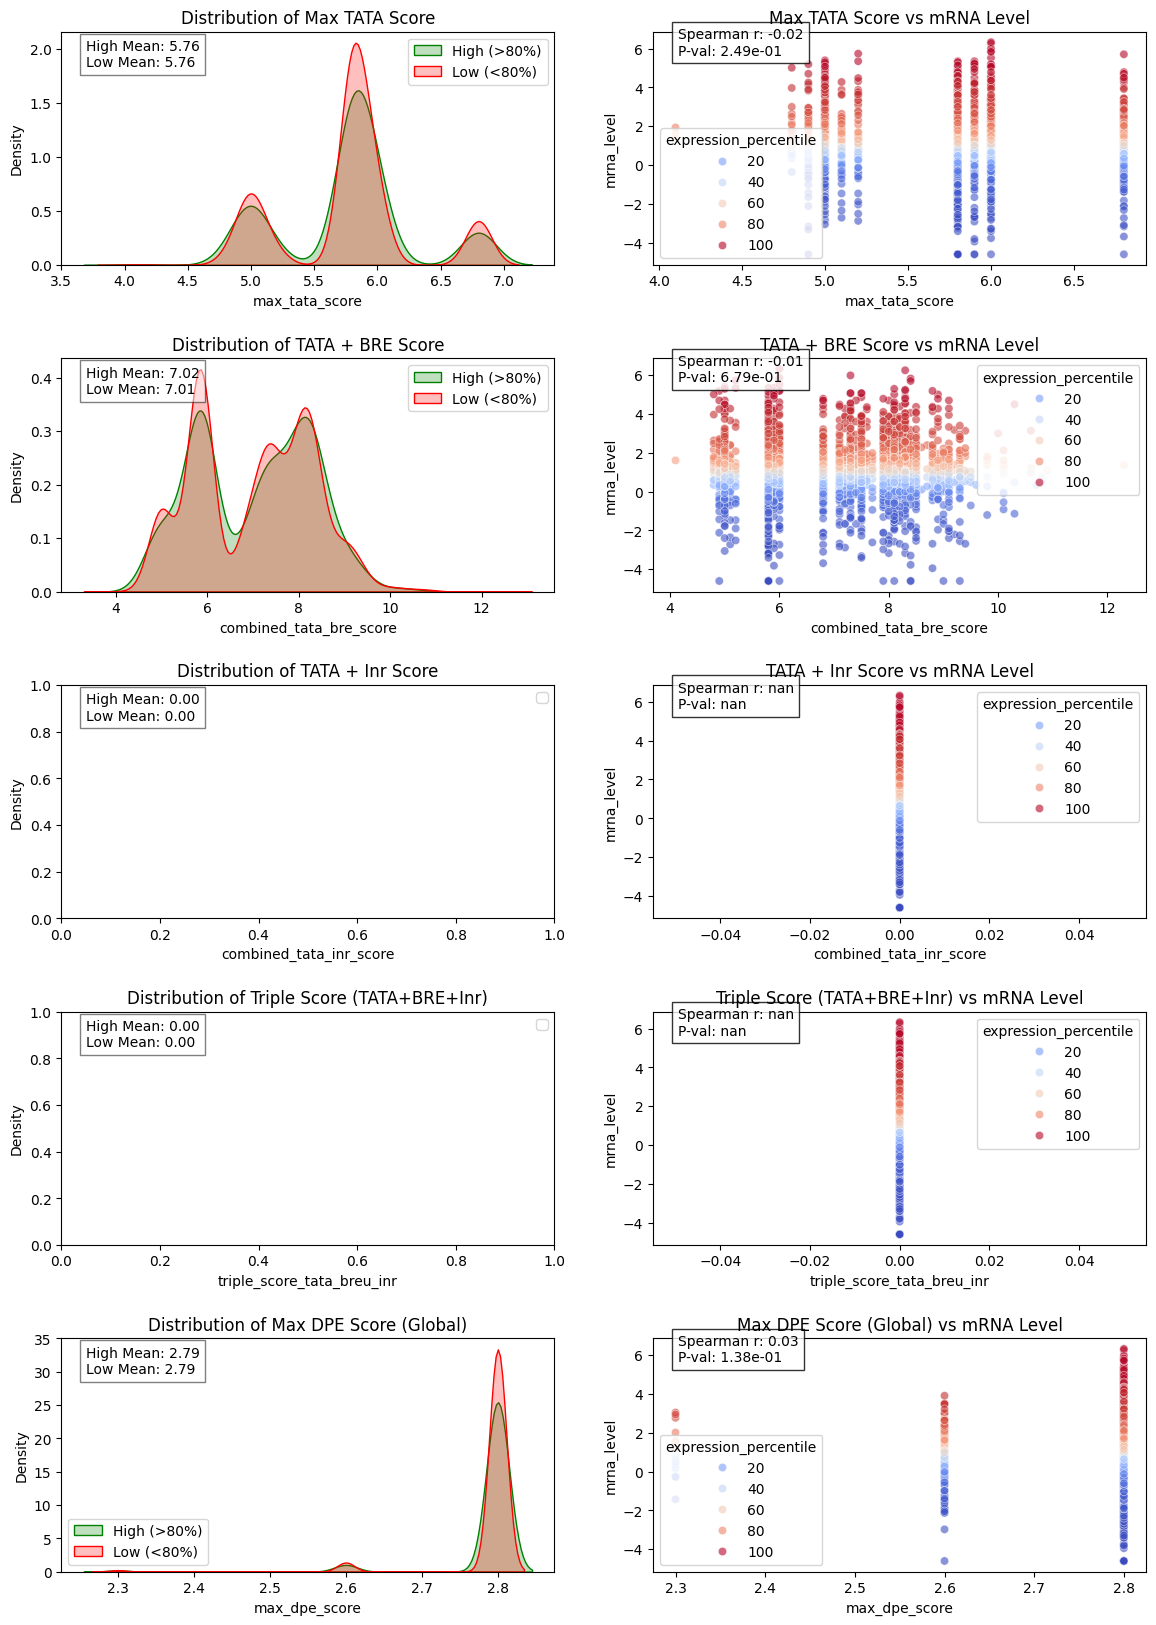


=== מסקנות והמלצות ===
- פיצ'ר Max TATA Score לא מראה קשר לינארי ברור לרמות הביטוי.
- פיצ'ר TATA + BRE Score לא מראה קשר לינארי ברור לרמות הביטוי.
- פיצ'ר TATA + Inr Score לא מראה קשר לינארי ברור לרמות הביטוי.
- פיצ'ר Triple Score (TATA+BRE+Inr) לא מראה קשר לינארי ברור לרמות הביטוי.
- פיצ'ר Max DPE Score (Global) לא מראה קשר לינארי ברור לרמות הביטוי.

המלצה כללית:
אם רואים שה-Triple Score או ה-Combined Score נותנים קורלציה טובה יותר מה-TATA לבד,
זה סימן שהארכיטקטורה המלאה (BRE/Inr) קריטית לביטוי בגנים אלו.
אם DPE נותן תוצאה גבוהה בגנים ללא TATA, יש להשתמש בו כפיצ'ר משלים.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================================
# 1. הגדרת המטריצות (PSSM) והגדרות ביולוגיות
# ==========================================

# הגדרת נוקליאוטידים למיפוי
nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': -1}

# --- TATA BOX (TATAWAW) ---
tata_pwm = np.array([
    [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0],
    [1.0, 0.0, 0.0, 0.0], [0.9, 0.0, 0.0, 0.1], [1.0, 0.0, 0.0, 0.0],
    [0.9, 0.0, 0.0, 0.1]
])

# --- INR (Initiator - PyPyAN(T/A)PyPy) ---
# מותאם לקונצנזוס YR (+1)
inr_pwm = np.array([
    [0.1, 0.4, 0.1, 0.4], [0.1, 0.4, 0.1, 0.4], [1.0, 0.0, 0.0, 0.0], # A at +1
    [0.2, 0.3, 0.2, 0.3], [0.1, 0.4, 0.1, 0.4], [0.1, 0.4, 0.1, 0.4]
])

# --- BRE-u (TFIIB Recognition Element Upstream) ---
# קונצנזוס G/C rich (SSRAGC)
bre_u_pwm = np.array([
    [0.0, 0.5, 0.5, 0.0], [0.0, 0.5, 0.5, 0.0], [0.5, 0.0, 0.5, 0.0],
    [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0]
])

# --- BRE-d (Downstream) ---
# קונצנזוס חלש יותר, לרוב RTDKKK
bre_d_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], [0.0, 0.0, 0.0, 1.0], [0.3, 0.3, 0.3, 0.1],
    [0.0, 0.0, 0.5, 0.5], [0.0, 0.0, 0.5, 0.5], [0.0, 0.0, 0.5, 0.5]
])

# --- DPE (Downstream Promoter Element) ---
# קונצנזוס RGWYV (נמצא כ-30 בסיסים אחרי ה-Inr)
dpe_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], [0.0, 0.0, 1.0, 0.0], [0.5, 0.0, 0.0, 0.5],
    [0.0, 0.5, 0.0, 0.5], [0.3, 0.3, 0.3, 0.1]
])

# ספי החלטה (ניתנים לשינוי)
THRESHOLDS = {
    'TATA': 4.0,
    'INR': 3.5,
    'BRE': 3.0,
    'DPE': 3.5
}

# ==========================================
# 2. פונקציות עזר לסריקה וניתוח
# ==========================================

def get_pwm_score(sequence_numeric, pwm):
    """מחשב ציון PSSM עבור מקטע ספציפי"""
    if len(sequence_numeric) != len(pwm): return -np.inf
    if -1 in sequence_numeric: return -np.inf
    return sum(pwm[i, sequence_numeric[i]] for i in range(len(pwm)))

def scan_sequence(seq_numeric, pwm):
    """סורק את כל הרצף ומחזיר מערך ציונים"""
    motif_len = len(pwm)
    scores = np.full(len(seq_numeric), -np.inf)
    for i in range(len(seq_numeric) - motif_len + 1):
        segment = seq_numeric[i:i+motif_len]
        if -1 not in segment:
            scores[i] = sum(pwm[j, segment[j]] for j in range(motif_len))
    return scores

def analyze_single_promoter(full_promoter_seq, mrna_level):
    # 1. התמקדות ב-Core Promoter (250 אחרונים)
    core_len = 250
    if len(full_promoter_seq) < core_len:
        seq = full_promoter_seq
    else:
        seq = full_promoter_seq[-core_len:]
    
    # המרה למספרים
    seq_num = [nucleotide_map.get(b, -1) for b in seq]
    
    # סריקה ראשונית של כל המוטיבים
    tata_scores = scan_sequence(seq_num, tata_pwm)
    inr_scores = scan_sequence(seq_num, inr_pwm)
    
    # חישוב DPE בלתי תלוי (לשימוש במקרים ללא TATA/Inr ברור)
    dpe_scores_raw = scan_sequence(seq_num, dpe_pwm)
    max_dpe_global = np.max(dpe_scores_raw) if len(dpe_scores_raw) > 0 else -np.inf
    
    # --- משתנים לאגירת תוצאות ---
    tata_candidates_count = 0
    
    best_tata_score = -np.inf
    best_tata_pos = -1
    
    match_bre_u_d_count = 0
    best_bre_u_score = -np.inf
    best_bre_d_score = -np.inf
    best_bre_u_pos = -1
    best_bre_d_pos = -1
    
    max_combined_tata_bre_score = -np.inf
    max_combined_tata_bre_pos = -1
    
    match_inr_count = 0
    best_inr_score = -np.inf
    best_inr_pos = -1
    best_inr_has_tata = False
    
    max_combined_tata_inr_score = -np.inf
    
    max_triple_score = -np.inf # TATA + BRE + INR
    
    # --- לוגיקת סריקה מבוססת TATA ---
    # מוצאים את כל ה-TATA הפוטנציאליים
    tata_indices = np.where(tata_scores >= THRESHOLDS['TATA'])[0]
    tata_candidates_count = len(tata_indices)
    
    if tata_candidates_count > 0:
        # מציאת TATA מקסימלי
        best_idx = tata_indices[np.argmax(tata_scores[tata_indices])]
        best_tata_score = tata_scores[best_idx]
        best_tata_pos = best_idx # מיקום יחסי ל-250 האחרונים
        
        # לולאה על כל המועמדים לבדיקת הקשרים (BRE/Inr)
        for idx in tata_indices:
            current_tata_score = tata_scores[idx]
            
            # -- בדיקת BRE --
            # BRE-u: מסתיים איפה ש-TATA מתחיל
            u_start = idx - len(bre_u_pwm)
            u_score = -np.inf
            if u_start >= 0:
                u_score = get_pwm_score(seq_num[u_start:idx], bre_u_pwm)
            
            # BRE-d: מתחיל איפה ש-TATA נגמר
            d_start = idx + len(tata_pwm)
            d_score = -np.inf
            if d_start + len(bre_d_pwm) <= len(seq_num):
                d_score = get_pwm_score(seq_num[d_start:d_start+len(bre_d_pwm)], bre_d_pwm)
            
            # האם יש גם וגם?
            if u_score >= THRESHOLDS['BRE'] and d_score >= THRESHOLDS['BRE']:
                match_bre_u_d_count += 1
            
            # שמירת מקסימום BRE (ללא תלות אם שניהם קיימים)
            if u_score > best_bre_u_score: 
                best_bre_u_score = u_score
                best_bre_u_pos = u_start
            if d_score > best_bre_d_score:
                best_bre_d_score = d_score
                best_bre_d_pos = d_start
                
            # ציון משולב TATA + BRE (נחמיר: דורש לפחות אחד מהם מעל הסף)
            combined_bre = current_tata_score
            if u_score > THRESHOLDS['BRE']: combined_bre += u_score
            if d_score > THRESHOLDS['BRE']: combined_bre += d_score
            
            if combined_bre > max_combined_tata_bre_score:
                max_combined_tata_bre_score = combined_bre
                max_combined_tata_bre_pos = idx

            # -- בדיקת Inr (ביחס ל-TATA הנוכחי) --
            # חלון חיפוש: 20-40 בסיסים אחרי תחילת TATA
            inr_search_start = idx + 20
            inr_search_end = min(idx + 45, len(seq_num) - len(inr_pwm))
            
            current_inr_max = -np.inf
            current_inr_pos = -1
            
            if inr_search_start < inr_search_end:
                local_inr_slice = inr_scores[inr_search_start:inr_search_end]
                if len(local_inr_slice) > 0:
                    local_max_idx = np.argmax(local_inr_slice)
                    if local_inr_slice[local_max_idx] >= THRESHOLDS['INR']:
                        current_inr_max = local_inr_slice[local_max_idx]
                        current_inr_pos = inr_search_start + local_max_idx
                        match_inr_count += 1
            
            # שקלול TATA + Inr
            if current_inr_max > -np.inf:
                combined_inr = current_tata_score + current_inr_max
                if combined_inr > max_combined_tata_inr_score:
                    max_combined_tata_inr_score = combined_inr
                
                # שקלול משולש: TATA + BREu + Inr
                # (נשתמש ב-BREu הספציפי של ה-TATA הזה)
                triple = current_tata_score + current_inr_max
                if u_score >= THRESHOLDS['BRE']:
                    triple += u_score
                
                if triple > max_triple_score:
                    max_triple_score = triple

    # --- מציאת ה-Inr המקסימלי הגלובלי (גם אם לא קשור ל-TATA) ---
    if len(inr_scores) > 0:
        global_inr_idx = np.argmax(inr_scores)
        if inr_scores[global_inr_idx] > best_inr_score: # אם מצאנו משהו טוב יותר או שאין כלום
            best_inr_score = inr_scores[global_inr_idx]
            best_inr_pos = global_inr_idx
            # בדיקה האם ה-Inr המנצח הזה "מגובה" ב-TATA
            # בודקים אחורה 20-40 בסיסים
            check_tata_start = max(0, best_inr_pos - 40)
            check_tata_end = max(0, best_inr_pos - 20)
            has_tata = False
            if check_tata_start < check_tata_end:
                 if np.any(tata_scores[check_tata_start:check_tata_end] >= THRESHOLDS['TATA']):
                     has_tata = True
            best_inr_has_tata = has_tata

    # --- טיפול בערכי ברירת מחדל (אם לא נמצא כלום) ---
    def clean_val(val, default=0):
        return val if val != -np.inf else default
    
    # המרה ל-Series להחזרה
    return pd.Series({
        'promoter_seq': full_promoter_seq,
        'mrna_level': mrna_level,
        'tata_opt_count': tata_candidates_count,
        'max_tata_score': clean_val(best_tata_score),
        'max_tata_pos': best_tata_pos if best_tata_score > -np.inf else -1,
        'tata_with_bre_ud_count': match_bre_u_d_count,
        'max_bre_u_score': clean_val(best_bre_u_score),
        'max_bre_u_pos': best_bre_u_pos if best_bre_u_score > -np.inf else -1,
        'max_bre_d_score': clean_val(best_bre_d_score),
        'max_bre_d_pos': best_bre_d_pos if best_bre_d_score > -np.inf else -1,
        'combined_tata_bre_score': clean_val(max_combined_tata_bre_score),
        'combined_tata_bre_pos': max_combined_tata_bre_pos if max_combined_tata_bre_score > -np.inf else -1,
        'tata_with_inr_count': match_inr_count,
        'max_inr_score': clean_val(best_inr_score),
        'max_inr_pos': best_inr_pos if best_inr_score > -np.inf else -1,
        'max_inr_has_tata': best_inr_has_tata,
        'combined_tata_inr_score': clean_val(max_combined_tata_inr_score),
        'triple_score_tata_breu_inr': clean_val(max_triple_score),
        'max_dpe_score': clean_val(max_dpe_global)
    })

# ==========================================
# 3. פונקציית מעטפת ראשית (Main)
# ==========================================

def process_promoter_data(csv_path):
    # טעינת נתונים
    try:
        # הנחה: אין כותרות, או להתאים לפי הקובץ שלך
        # אם יש כותרות, שנה ל-header=0
        df = pd.read_csv(csv_path)
        # וודא שהעמודות נקראות נכון, נניח שהראשונה היא רצף והשניה ביטוי
        df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("שגיאה בטעינת הקובץ. וודא פורמט CSV תקין.")
        return None

    print(f"מעבד {len(df)} פרומוטורים... זה יקח רגע.")
    
    # הרצת האנליזה על כל שורה
    results = df.apply(lambda row: analyze_single_promoter(row['promoter'], row['mrna_level']), axis=1)
    
    # חישוב אחוזונים (Highly Expressed)
    results['expression_percentile'] = results['mrna_level'].rank(pct=True) * 100
    
    # סידור העמודות לפי הסדר שביקשת
    cols_order = [
        'promoter_seq', 'mrna_level', 'expression_percentile',
        'tata_opt_count', 
        'max_tata_score', 'max_tata_pos',
        'tata_with_bre_ud_count',
        'max_bre_u_score', 'max_bre_u_pos', 'max_bre_d_score', 'max_bre_d_pos',
        'combined_tata_bre_score', 'combined_tata_bre_pos',
        'tata_with_inr_count',
        'max_inr_score', 'max_inr_pos', 'max_inr_has_tata',
        'combined_tata_inr_score',
        'triple_score_tata_breu_inr',
        'max_dpe_score'
    ]
    final_df = results[cols_order]
    
    return final_df

def generate_statistics_and_plots(df):
    print("\n=== סטטיסטיקה ומסקנות ===")
    
    # 1. כמה עם TATA ולכמה אין (לפי המקסימום)
    has_tata = len(df[df['max_tata_score'] > 0]) # 0 זה ה-Default אם לא עבר סף
    no_tata = len(df) - has_tata
    print(f"1. פרומוטרים עם TATA (ציון > {THRESHOLDS['TATA']}): {has_tata} ({has_tata/len(df)*100:.1f}%)")
    print(f"   פרומוטרים ללא TATA מזוהה: {no_tata}")

    # הגדרת קבוצות
    high_exp = df[df['expression_percentile'] >= 80]
    low_exp = df[df['expression_percentile'] < 80]
    
    # רשימת הפיצ'רים לניתוח גרפי
    features_to_plot = [
        ('max_tata_score', 'Max TATA Score'),
        ('combined_tata_bre_score', 'TATA + BRE Score'),
        ('combined_tata_inr_score', 'TATA + Inr Score'),
        ('triple_score_tata_breu_inr', 'Triple Score (TATA+BRE+Inr)'),
        ('max_dpe_score', 'Max DPE Score (Global)')
    ]
    
    # יצירת גרפים
    fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(14, 4 * len(features_to_plot)))
    plt.subplots_adjust(hspace=0.4)
    
    conclusions = []
    
    for i, (col, title) in enumerate(features_to_plot):
        # סינון אפסים (אם רוצים לראות רק היכן שנמצא מוטיב) - אופציונלי. כאן נציג הכל.
        
        # --- צד שמאל: התפלגות ---
        ax_dist = axes[i, 0]
        sns.kdeplot(data=high_exp, x=col, fill=True, label='High (>80%)', ax=ax_dist, color='green')
        sns.kdeplot(data=low_exp, x=col, fill=True, label='Low (<80%)', ax=ax_dist, color='red')
        ax_dist.set_title(f'Distribution of {title}')
        ax_dist.legend()
        
        # חישוב מדדים
        mean_high = high_exp[col].mean()
        mean_low = low_exp[col].mean()
        ax_dist.text(0.05, 0.85, f"High Mean: {mean_high:.2f}\nLow Mean: {mean_low:.2f}", 
                     transform=ax_dist.transAxes, bbox=dict(facecolor='white', alpha=0.5))

        # --- צד ימין: קורלציה מול mRNA ---
        ax_scat = axes[i, 1]
        sns.scatterplot(data=df, x=col, y='mrna_level', hue='expression_percentile', 
                        palette='coolwarm', ax=ax_scat, alpha=0.6)
        ax_scat.set_title(f'{title} vs mRNA Level')
        
        # קורלציה
        corr, p_val = stats.spearmanr(df[col], df['mrna_level'])
        ax_scat.text(0.05, 0.9, f"Spearman r: {corr:.2f}\nP-val: {p_val:.2e}", 
                     transform=ax_scat.transAxes, bbox=dict(facecolor='white', alpha=0.8))
        
        # הסקת מסקנות אוטומטית
        if abs(corr) > 0.3:
            impact = "Positive" if corr > 0 else "Negative"
            conclusions.append(f"פיצ'ר {title} מראה קורלציה משמעותית ({corr:.2f}). השפעה: {impact}.")
        elif abs(corr) > 0.1:
             conclusions.append(f"פיצ'ר {title} מראה קורלציה חלשה ({corr:.2f}).")
        else:
             conclusions.append(f"פיצ'ר {title} לא מראה קשר לינארי ברור לרמות הביטוי.")

    plt.show()
    
    print("\n=== מסקנות והמלצות ===")
    for c in conclusions:
        print(f"- {c}")
        
    print("\nהמלצה כללית:")
    print("אם רואים שה-Triple Score או ה-Combined Score נותנים קורלציה טובה יותר מה-TATA לבד,")
    print("זה סימן שהארכיטקטורה המלאה (BRE/Inr) קריטית לביטוי בגנים אלו.")
    print("אם DPE נותן תוצאה גבוהה בגנים ללא TATA, יש להשתמש בו כפיצ'ר משלים.")

# ==========================================
# הרצה (יש להחליף את שם הקובץ)
# ==========================================
final_df = process_promoter_data('train2.csv') 
if final_df is not None:
     generate_statistics_and_plots(final_df)
# שמירה
final_df.to_csv('detailed_promoter_analysis_tarin2.csv', index=False)

# גרסה מקלה יותר בספים

מעבד 3194 פרומוטורים... זה יקח רגע.

=== סטטיסטיקה ומסקנות ===
1. פרומוטרים עם TATA (ציון > 0): 3194 (100.0%)
   פרומוטרים ללא TATA מזוהה: 0


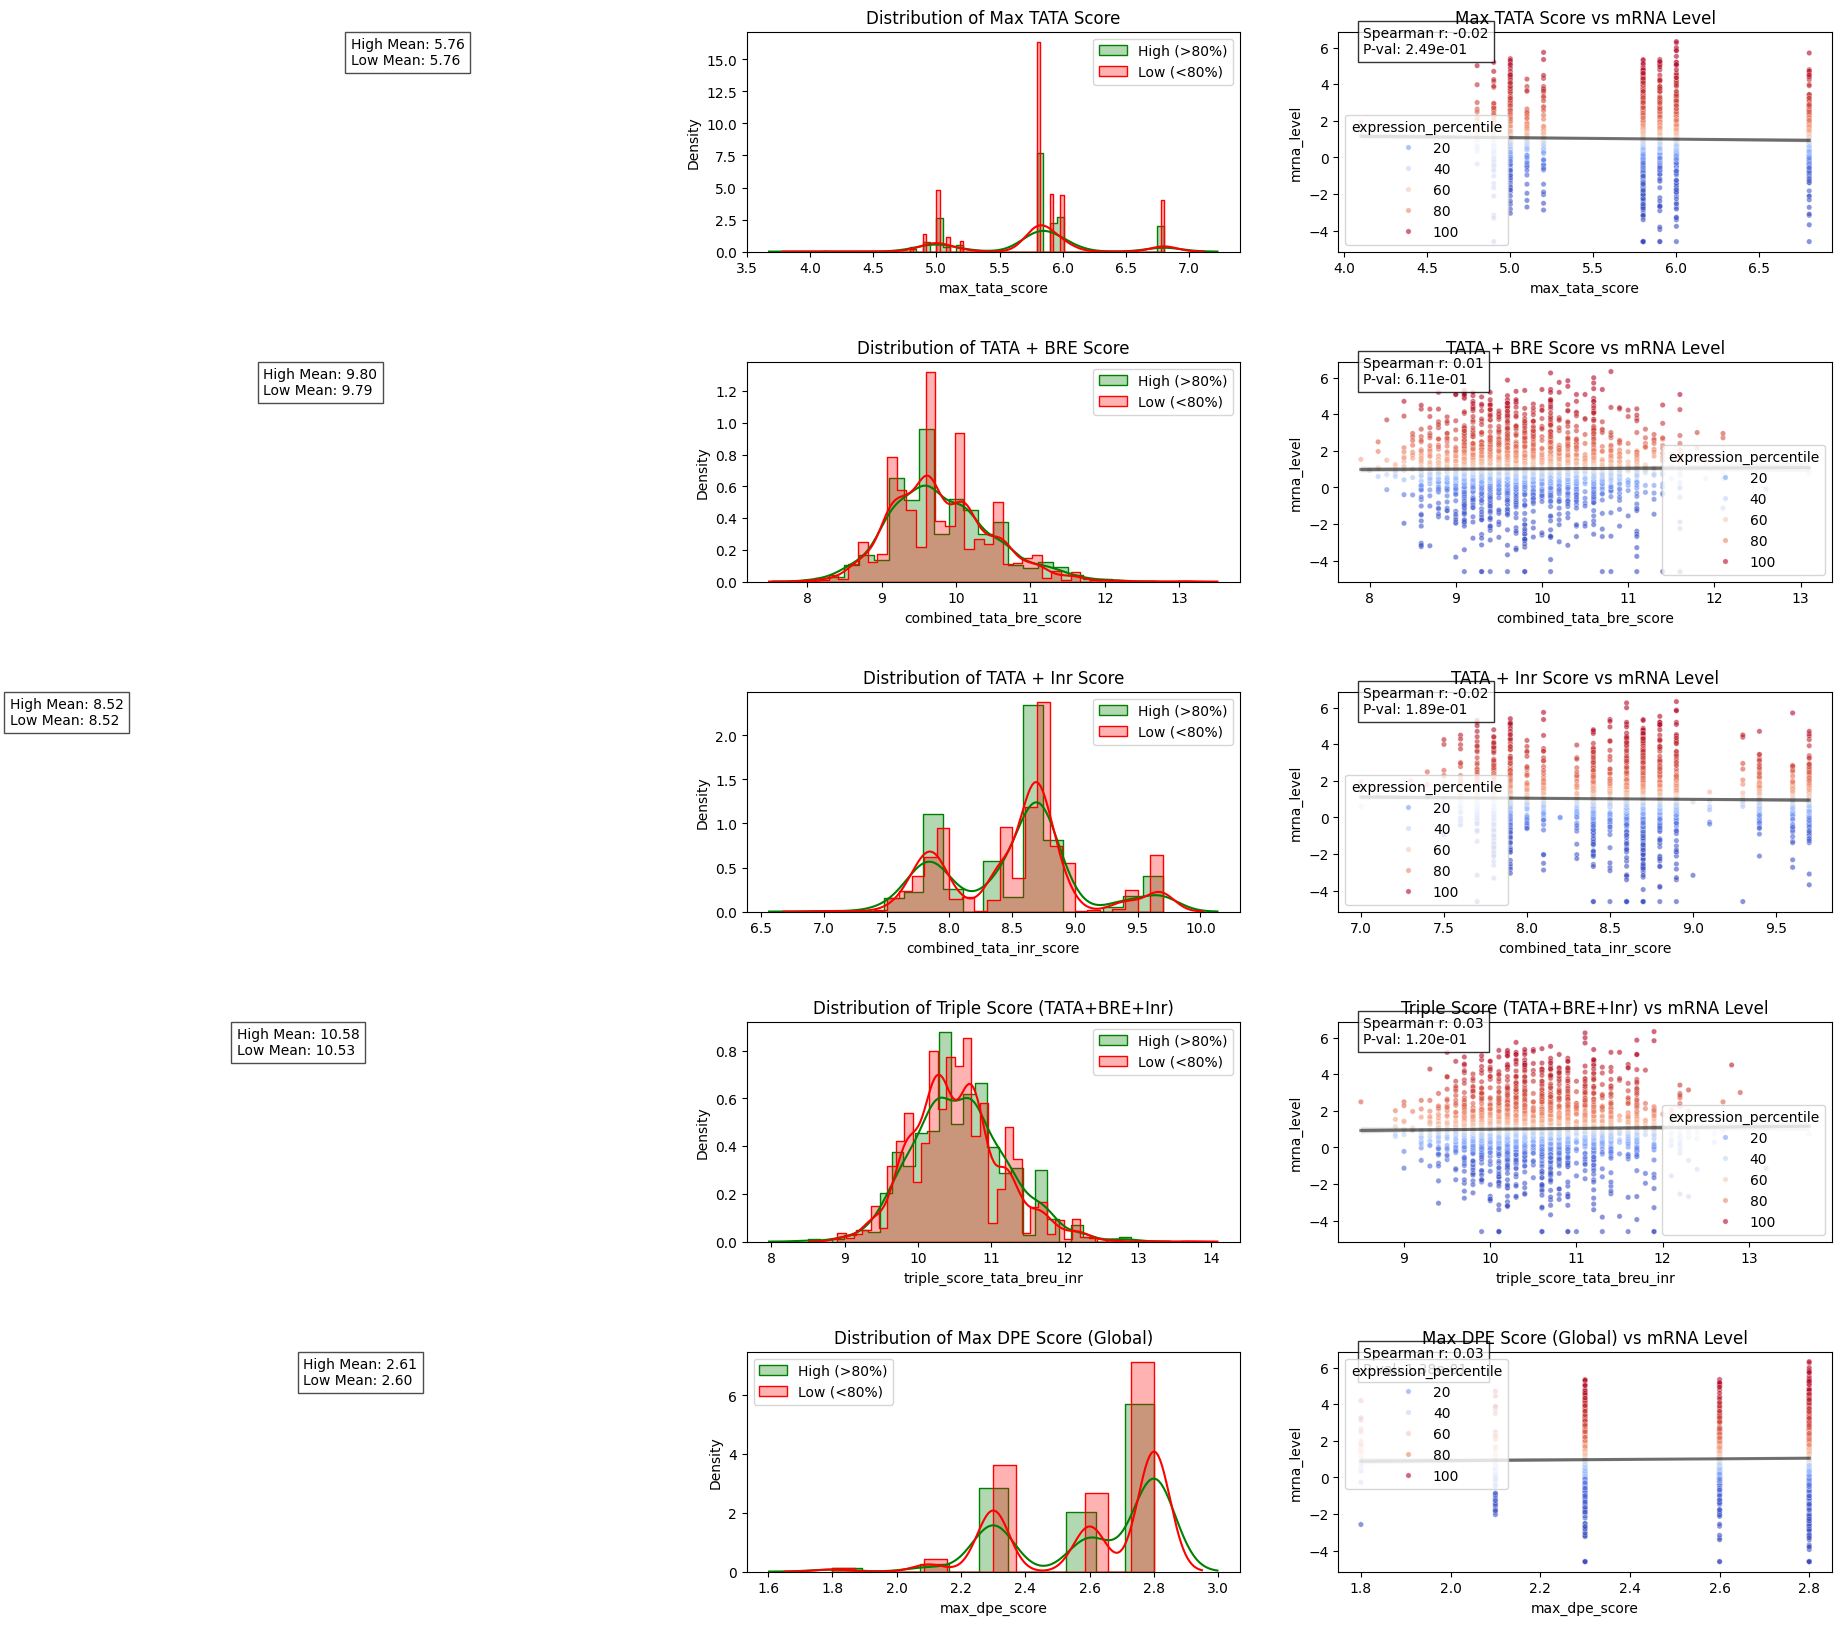


=== סיכום מסקנות אוטומטי ===
לא נמצאו קורלציות חזקות במיוחד (>0.25).


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================================
# 1. הגדרת המטריצות (PSSM) והגדרות ביולוגיות
# ==========================================

# הגדרת נוקליאוטידים למיפוי
nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': -1}

# --- TATA BOX (TATAWAW) ---
tata_pwm = np.array([
    [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0],
    [1.0, 0.0, 0.0, 0.0], [0.9, 0.0, 0.0, 0.1], [1.0, 0.0, 0.0, 0.0],
    [0.9, 0.0, 0.0, 0.1]
])

# --- INR (Initiator - PyPyAN(T/A)PyPy) ---
# מותאם לקונצנזוס YR (+1)
inr_pwm = np.array([
    [0.1, 0.4, 0.1, 0.4], [0.1, 0.4, 0.1, 0.4], [1.0, 0.0, 0.0, 0.0], # A at +1
    [0.2, 0.3, 0.2, 0.3], [0.1, 0.4, 0.1, 0.4], [0.1, 0.4, 0.1, 0.4]
])

# --- BRE-u (TFIIB Recognition Element Upstream) ---
# קונצנזוס G/C rich (SSRAGC)
bre_u_pwm = np.array([
    [0.0, 0.5, 0.5, 0.0], [0.0, 0.5, 0.5, 0.0], [0.5, 0.0, 0.5, 0.0],
    [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0]
])

# --- BRE-d (Downstream) ---
# קונצנזוס חלש יותר, לרוב RTDKKK
bre_d_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], [0.0, 0.0, 0.0, 1.0], [0.3, 0.3, 0.3, 0.1],
    [0.0, 0.0, 0.5, 0.5], [0.0, 0.0, 0.5, 0.5], [0.0, 0.0, 0.5, 0.5]
])

# --- DPE (Downstream Promoter Element) ---
# קונצנזוס RGWYV (נמצא כ-30 בסיסים אחרי ה-Inr)
dpe_pwm = np.array([
    [0.5, 0.0, 0.5, 0.0], [0.0, 0.0, 1.0, 0.0], [0.5, 0.0, 0.0, 0.5],
    [0.0, 0.5, 0.0, 0.5], [0.3, 0.3, 0.3, 0.1]
])

# ספי החלטה חדשים ("סלחניים" יותר)
THRESHOLDS = {
    'TATA': 2.0,   # הורדנו מ-4.0 - יתפוס גם TATA בינוני
    'INR': 1.5,    # הורדנו מ-3.5 - יתפוס Inr חלש (נפוץ מאוד)
    'BRE': 1.0,    # מספיק דמיון קל ל-GC rich
    'DPE': 2.0     # הורדנו סף
}
# ==========================================
# 2. פונקציות עזר לסריקה וניתוח
# ==========================================

def get_pwm_score(sequence_numeric, pwm):
    """מחשב ציון PSSM עבור מקטע ספציפי"""
    if len(sequence_numeric) != len(pwm): return -np.inf
    if -1 in sequence_numeric: return -np.inf
    return sum(pwm[i, sequence_numeric[i]] for i in range(len(pwm)))

def scan_sequence(seq_numeric, pwm):
    """סורק את כל הרצף ומחזיר מערך ציונים"""
    motif_len = len(pwm)
    scores = np.full(len(seq_numeric), -np.inf)
    for i in range(len(seq_numeric) - motif_len + 1):
        segment = seq_numeric[i:i+motif_len]
        if -1 not in segment:
            scores[i] = sum(pwm[j, segment[j]] for j in range(motif_len))
    return scores

def analyze_single_promoter(full_promoter_seq, mrna_level):
    # 1. התמקדות ב-Core Promoter
    core_len = 250
    if len(full_promoter_seq) < core_len:
        seq = full_promoter_seq
    else:
        seq = full_promoter_seq[-core_len:]
    
    seq_num = [nucleotide_map.get(b, -1) for b in seq]
    
    # סריקה
    tata_scores = scan_sequence(seq_num, tata_pwm)
    inr_scores = scan_sequence(seq_num, inr_pwm)
    
    # משתנים לאגירה
    tata_candidates_count = 0
    best_tata_score = -np.inf
    best_tata_pos = -1
    
    match_bre_u_d_count = 0
    best_bre_u_score = -np.inf
    best_bre_d_score = -np.inf
    best_bre_u_pos = -1
    best_bre_d_pos = -1
    
    max_combined_tata_bre_score = -np.inf
    max_combined_tata_bre_pos = -1
    
    match_inr_count = 0
    best_inr_score = -np.inf
    best_inr_pos = -1
    best_inr_has_tata = False
    
    max_combined_tata_inr_score = -np.inf
    max_triple_score = -np.inf 
    max_dpe_val = -np.inf # DPE
    
    # --- לוגיקה מעודכנת ---
    
    # 1. זיהוי TATA (עם סף נמוך)
    tata_indices = np.where(tata_scores >= THRESHOLDS['TATA'])[0]
    tata_candidates_count = len(tata_indices)
    
    if tata_candidates_count > 0:
        best_idx = tata_indices[np.argmax(tata_scores[tata_indices])]
        best_tata_score = tata_scores[best_idx]
        best_tata_pos = best_idx
        
        for idx in tata_indices:
            current_tata_score = tata_scores[idx]
            
            # בדיקת BRE (ללא שינוי מהותי, רק הסף ירד)
            u_start = idx - len(bre_u_pwm)
            u_score = -np.inf
            if u_start >= 0:
                u_score = get_pwm_score(seq_num[u_start:idx], bre_u_pwm)
            
            d_start = idx + len(tata_pwm)
            d_score = -np.inf
            if d_start + len(bre_d_pwm) <= len(seq_num):
                d_score = get_pwm_score(seq_num[d_start:d_start+len(bre_d_pwm)], bre_d_pwm)
            
            if u_score >= THRESHOLDS['BRE'] and d_score >= THRESHOLDS['BRE']:
                match_bre_u_d_count += 1
            
            if u_score > best_bre_u_score: 
                best_bre_u_score = u_score
                best_bre_u_pos = u_start
            if d_score > best_bre_d_score:
                best_bre_d_score = d_score
                best_bre_d_pos = d_start
            
            # חישוב משולב TATA + BRE
            combined_bre = current_tata_score + max(0, u_score) + max(0, d_score)
            if combined_bre > max_combined_tata_bre_score:
                max_combined_tata_bre_score = combined_bre
                max_combined_tata_bre_pos = idx

            # --- הרחבת חלון החיפוש ל-Inr ---
            # במקום 20-45, נפתח ל-15-60
            inr_search_start = idx + 15
            inr_search_end = min(idx + 60, len(seq_num) - len(inr_pwm))
            
            current_inr_max = -np.inf
            
            if inr_search_start < inr_search_end:
                local_inr_slice = inr_scores[inr_search_start:inr_search_end]
                if len(local_inr_slice) > 0:
                    local_max_idx = np.argmax(local_inr_slice)
                    # בדיקה אם עובר את הסף החדש והנמוך
                    if local_inr_slice[local_max_idx] >= THRESHOLDS['INR']:
                        current_inr_max = local_inr_slice[local_max_idx]
                        match_inr_count += 1
                        
                        # --- חיפוש DPE ממוקד ---
                        # DPE נמצא בדיוק 28-32 בסיסים אחרי ה-Inr הזה
                        inr_abs_pos = inr_search_start + local_max_idx
                        dpe_start = inr_abs_pos + 28
                        dpe_end = inr_abs_pos + 33 # חלון קטן סביב +30
                        
                        if dpe_end + len(dpe_pwm) <= len(seq_num):
                            # סורקים את האזור הקטן הזה ל-DPE
                            dpe_local_scores = scan_sequence(seq_num[dpe_start:dpe_end+5], dpe_pwm)
                            local_dpe_best = np.max(dpe_local_scores) if len(dpe_local_scores) > 0 else -np.inf
                            if local_dpe_best > max_dpe_val:
                                max_dpe_val = local_dpe_best
            
            if current_inr_max > -np.inf:
                combined_inr = current_tata_score + current_inr_max
                if combined_inr > max_combined_tata_inr_score:
                    max_combined_tata_inr_score = combined_inr
                
                triple = current_tata_score + current_inr_max + max(0, u_score)
                if triple > max_triple_score:
                    max_triple_score = triple

    # Fallback ל-DPE ו-Inr אם לא מצאנו דרך TATA
    if max_dpe_val == -np.inf:
         # סריקה עיוורת בסוף הרצף (אזור ה-UTR המשוער)
         dpe_blind = scan_sequence(seq_num[-100:], dpe_pwm)
         if len(dpe_blind) > 0:
             max_dpe_val = np.max(dpe_blind)

    if len(inr_scores) > 0:
        global_inr_idx = np.argmax(inr_scores)
        if inr_scores[global_inr_idx] > best_inr_score: 
            best_inr_score = inr_scores[global_inr_idx]
            best_inr_pos = global_inr_idx
            
            check_tata_start = max(0, best_inr_pos - 60) # הרחבנו גם פה
            check_tata_end = max(0, best_inr_pos - 15)
            has_tata = False
            if check_tata_start < check_tata_end:
                 if np.any(tata_scores[check_tata_start:check_tata_end] >= THRESHOLDS['TATA']):
                     has_tata = True
            best_inr_has_tata = has_tata

    def clean_val(val, default=0):
        return val if val != -np.inf else default
    
    return pd.Series({
        'promoter_seq': full_promoter_seq,
        'mrna_level': mrna_level,
        'tata_opt_count': tata_candidates_count,
        'max_tata_score': clean_val(best_tata_score),
        'max_tata_pos': best_tata_pos if best_tata_score > -np.inf else -1,
        'tata_with_bre_ud_count': match_bre_u_d_count,
        'max_bre_u_score': clean_val(best_bre_u_score),
        'max_bre_u_pos': best_bre_u_pos if best_bre_u_score > -np.inf else -1,
        'max_bre_d_score': clean_val(best_bre_d_score),
        'max_bre_d_pos': best_bre_d_pos if best_bre_d_score > -np.inf else -1,
        'combined_tata_bre_score': clean_val(max_combined_tata_bre_score),
        'combined_tata_bre_pos': max_combined_tata_bre_pos if max_combined_tata_bre_score > -np.inf else -1,
        'tata_with_inr_count': match_inr_count,
        'max_inr_score': clean_val(best_inr_score),
        'max_inr_pos': best_inr_pos if best_inr_score > -np.inf else -1,
        'max_inr_has_tata': best_inr_has_tata,
        'combined_tata_inr_score': clean_val(max_combined_tata_inr_score),
        'triple_score_tata_breu_inr': clean_val(max_triple_score),
        'max_dpe_score': clean_val(max_dpe_val)
    })
# ==========================================
# 3. פונקציית מעטפת ראשית (Main)
# ==========================================

def process_promoter_data(csv_path):
    # טעינת נתונים
    try:
        # הנחה: אין כותרות, או להתאים לפי הקובץ שלך
        # אם יש כותרות, שנה ל-header=0
        df = pd.read_csv(csv_path)
        # וודא שהעמודות נקראות נכון, נניח שהראשונה היא רצף והשניה ביטוי
        df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except:
        print("שגיאה בטעינת הקובץ. וודא פורמט CSV תקין.")
        return None

    print(f"מעבד {len(df)} פרומוטורים... זה יקח רגע.")
    
    # הרצת האנליזה על כל שורה
    results = df.apply(lambda row: analyze_single_promoter(row['promoter'], row['mrna_level']), axis=1)
    
    # חישוב אחוזונים (Highly Expressed)
    results['expression_percentile'] = results['mrna_level'].rank(pct=True) * 100
    
    # סידור העמודות לפי הסדר שביקשת
    cols_order = [
        'promoter_seq', 'mrna_level', 'expression_percentile',
        'tata_opt_count', 
        'max_tata_score', 'max_tata_pos',
        'tata_with_bre_ud_count',
        'max_bre_u_score', 'max_bre_u_pos', 'max_bre_d_score', 'max_bre_d_pos',
        'combined_tata_bre_score', 'combined_tata_bre_pos',
        'tata_with_inr_count',
        'max_inr_score', 'max_inr_pos', 'max_inr_has_tata',
        'combined_tata_inr_score',
        'triple_score_tata_breu_inr',
        'max_dpe_score'
    ]
    final_df = results[cols_order]
    
    return final_df

def generate_statistics_and_plots(df):
    print("\n=== סטטיסטיקה ומסקנות ===")
    
    # 1. בדיקת נוכחות TATA
    # אנו בודקים אם הציון חיובי (מעל 0 או מעל הסף שהוגדר כברירת מחדל לחיפוש)
    has_tata = len(df[df['max_tata_score'] > 0]) 
    no_tata = len(df) - has_tata
    print(f"1. פרומוטרים עם TATA (ציון > 0): {has_tata} ({has_tata/len(df)*100:.1f}%)")
    print(f"   פרומוטרים ללא TATA מזוהה: {no_tata}")

    # הגדרת קבוצות (High vs Low)
    high_exp = df[df['expression_percentile'] >= 80].copy()
    low_exp = df[df['expression_percentile'] < 80].copy()
    
    # רשימת הפיצ'רים לניתוח גרפי
    features_to_plot = [
        ('max_tata_score', 'Max TATA Score'),
        ('combined_tata_bre_score', 'TATA + BRE Score'),
        ('combined_tata_inr_score', 'TATA + Inr Score'),
        ('triple_score_tata_breu_inr', 'Triple Score (TATA+BRE+Inr)'),
        ('max_dpe_score', 'Max DPE Score (Global)')
    ]
    
    # יצירת גרפים
    fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(14, 4 * len(features_to_plot)))
    plt.subplots_adjust(hspace=0.5)
    
    conclusions = []
    
    for i, (col, title) in enumerate(features_to_plot):
        # --- צד שמאל: התפלגות (Histogram במקום KDE) ---
        ax_dist = axes[i, 0]
        
        # בדיקה האם יש בכלל שונות בנתונים (כדי למנוע את האזהרה)
        std_high = high_exp[col].std()
        std_low = low_exp[col].std()
        
        # שימוש ב-histplot שהוא יותר יציב לנתונים דלילים (הרבה אפסים)
        # stat="density" מנרמל כדי שנוכל להשוות בין הקבוצות למרות שהן בגדלים שונים
        sns.histplot(data=high_exp, x=col, color='green', label='High (>80%)', 
                     ax=ax_dist, stat="density", element="step", common_norm=False, alpha=0.3)
        sns.histplot(data=low_exp, x=col, color='red', label='Low (<80%)', 
                     ax=ax_dist, stat="density", element="step", common_norm=False, alpha=0.3)
        
        # הוספת קו KDE רק אם יש שונות (נתונים לא קבועים)
        if std_high > 0:
            sns.kdeplot(data=high_exp, x=col, color='green', ax=ax_dist, warn_singular=False)
        if std_low > 0:
            sns.kdeplot(data=low_exp, x=col, color='red', ax=ax_dist, warn_singular=False)

        ax_dist.set_title(f'Distribution of {title}')
        ax_dist.legend()
        
        # חישוב מדדים והצגתם על הגרף
        mean_high = high_exp[col].mean()
        mean_low = low_exp[col].mean()
        # מיקום הטקסט
        y_lim = ax_dist.get_ylim()[1]
        ax_dist.text(0.05 * ax_dist.get_xlim()[1], 0.85 * y_lim, 
                     f"High Mean: {mean_high:.2f}\nLow Mean: {mean_low:.2f}", 
                     bbox=dict(facecolor='white', alpha=0.7))

        # --- צד ימין: קורלציה מול mRNA ---
        ax_scat = axes[i, 1]
        
        # כאן נצייר Scatter פשוט יותר כדי לא להכביד
        sns.scatterplot(data=df, x=col, y='mrna_level', hue='expression_percentile', 
                        palette='coolwarm', ax=ax_scat, alpha=0.6, s=15)
        
        # קו רגרסיה (רק כדי לראות מגמה)
        sns.regplot(data=df, x=col, y='mrna_level', scatter=False, ax=ax_scat, color='black', line_kws={'alpha':0.5})
        
        ax_scat.set_title(f'{title} vs mRNA Level')
        
        # חישוב קורלציה
        # אם כל הערכים הם 0, הקורלציה תהיה NaN. מטפלים בזה:
        if df[col].std() > 0:
            corr, p_val = stats.spearmanr(df[col], df['mrna_level'])
            ax_scat.text(0.05, 0.9, f"Spearman r: {corr:.2f}\nP-val: {p_val:.2e}", 
                         transform=ax_scat.transAxes, bbox=dict(facecolor='white', alpha=0.8))
            
            # הסקת מסקנות
            if abs(corr) > 0.25:
                impact = "חיובית" if corr > 0 else "שלילית"
                conclusions.append(f"פיצ'ר {title}: קורלציה {impact} ({corr:.2f}).")
        else:
            ax_scat.text(0.1, 0.5, "No Variance in Feature", transform=ax_scat.transAxes)
            conclusions.append(f"פיצ'ר {title}: אין שונות בנתונים (כנראה לא נמצא מוטיב זהה).")

    plt.show()
    
    print("\n=== סיכום מסקנות אוטומטי ===")
    if not conclusions:
        print("לא נמצאו קורלציות חזקות במיוחד (>0.25).")
    for c in conclusions:
        print(f"- {c}")

# ==========================================
# הרצה (יש להחליף את שם הקובץ)
# ==========================================
final_df = process_promoter_data('train2.csv') 
if final_df is not None:
     generate_statistics_and_plots(final_df)
# שמירה
final_df.to_csv('detailed_promoter_analysis_train2.csv', index=False)


=== מבחן הקיצון המאוזן (Top 10% vs Bottom 10%) ===
משווים 319 גנים הכי חזקים מול 319 גנים הכי חלשים.


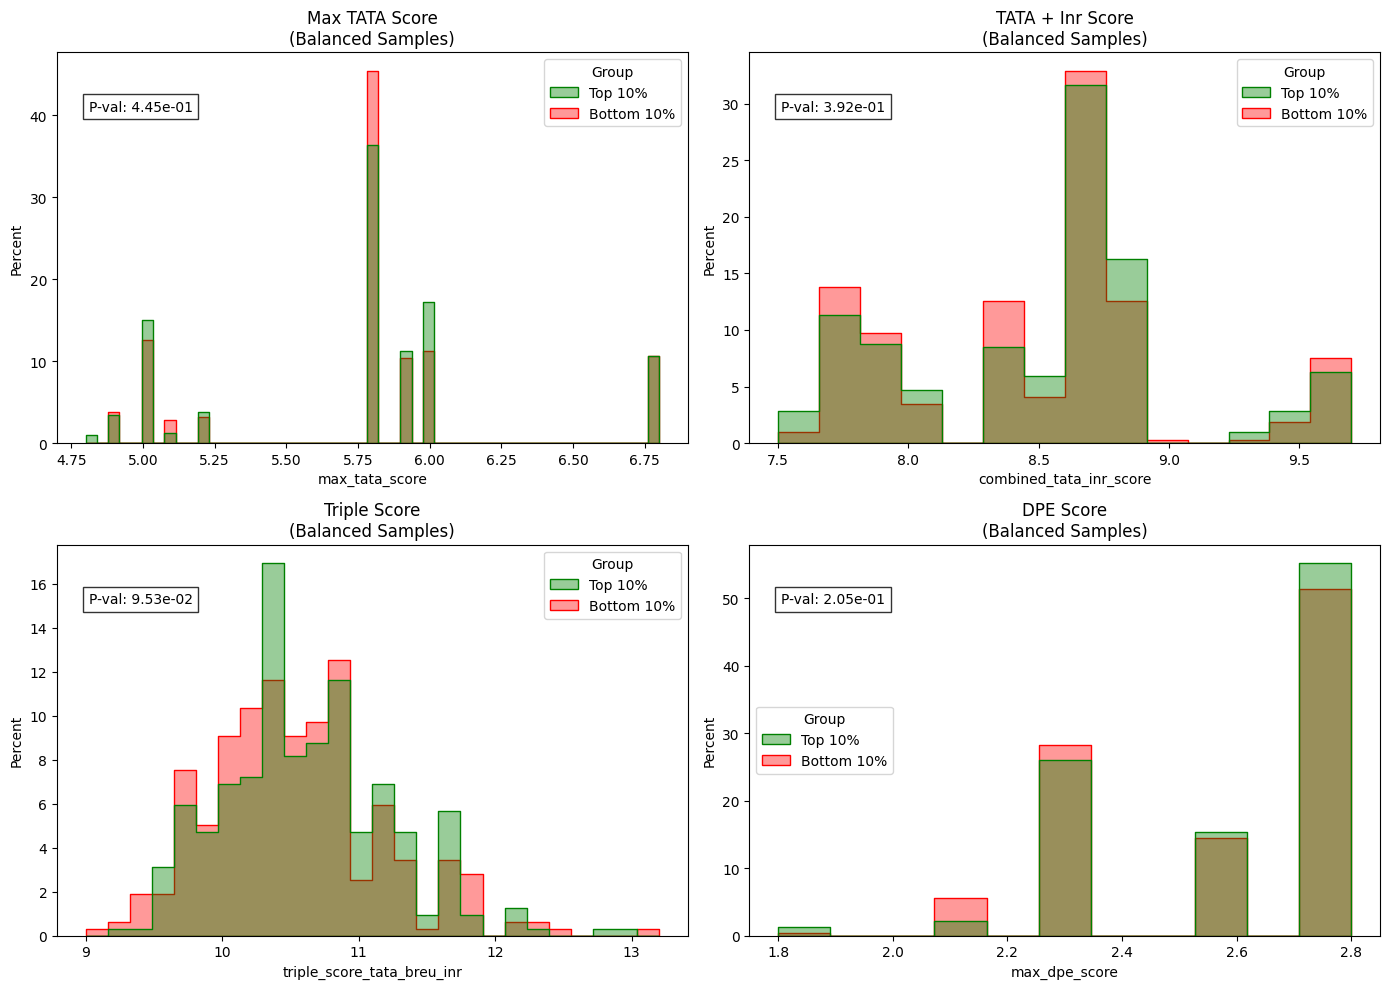

In [43]:
def plot_balanced_extremes(df):
    print("\n=== מבחן הקיצון המאוזן (Top 10% vs Bottom 10%) ===")
    
    # 1. הגדרת מקרי הקיצון
    top_threshold = 90  # אחוזון 90 ומעלה
    bottom_threshold = 10 # אחוזון 10 ומטה
    
    high_group = df[df['expression_percentile'] >= top_threshold].copy()
    low_group = df[df['expression_percentile'] <= bottom_threshold].copy()
    
    # 2. איזון הכמויות (Downsampling)
    # אנחנו רוצים ששתי הקבוצות יהיו באותו גודל בדיוק כדי שהעין לא תוטעה
    min_size = min(len(high_group), len(low_group))
    
    high_balanced = high_group.sample(n=min_size, random_state=42)
    low_balanced = low_group.sample(n=min_size, random_state=42)
    
    print(f"משווים {min_size} גנים הכי חזקים מול {min_size} גנים הכי חלשים.")
    
    # איחוד לצורך ציור
    high_balanced['Group'] = 'Top 10%'
    low_balanced['Group'] = 'Bottom 10%'
    combined_df = pd.concat([high_balanced, low_balanced])
    
    # 3. ציור הגרפים
    features = [
        ('max_tata_score', 'Max TATA Score'),
        ('combined_tata_inr_score', 'TATA + Inr Score'),
        ('triple_score_tata_breu_inr', 'Triple Score'),
        ('max_dpe_score', 'DPE Score')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # שימוש ב-histplot עם 'layer' כדי לראות חפיפה ברורה
        sns.histplot(data=combined_df, x=col, hue='Group', 
                     element="step", stat="percent", common_norm=False,
                     palette={'Top 10%': 'green', 'Bottom 10%': 'red'}, 
                     ax=ax, alpha=0.4)
        
        ax.set_title(f'{title}\n(Balanced Samples)')
        
        # בדיקת מובהקות (מבחן Mann-Whitney)
        stat, p_val = stats.mannwhitneyu(high_balanced[col], low_balanced[col])
        ax.text(0.05, 0.85, f"P-val: {p_val:.2e}", transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# הרצה על ה-DataFrame הקיים שלך
plot_balanced_extremes(final_df)